Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 24)        3480      
_________________________________________________________________
activation_2 (Activation)    (None, 75, 75, 24)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 24)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 35, 35, 32)       

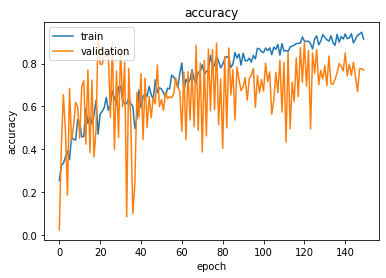

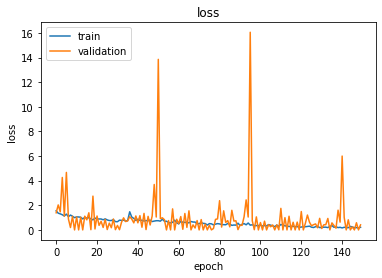

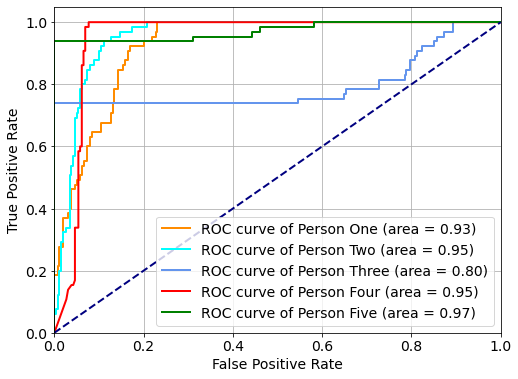

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

  Person One       0.76      0.38      0.51        65
  Person Two       0.76      0.74      0.75        65
Person Three       0.66      0.74      0.70        65
 Person Four       0.76      1.00      0.87        65
 Person Five       1.00      0.92      0.96        65

   micro avg       0.78      0.76      0.77       325
   macro avg       0.79      0.76      0.76       325
weighted avg       0.79      0.76      0.76       325
 samples avg       0.76      0.76      0.76       325

Confusion matrix, without normalization


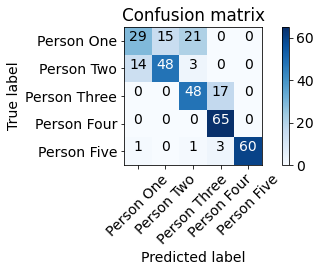

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jul 24 14:10:57 2020

@author: anik
"""
import tensorflow as tf
#config = tf.ConfigProto()
#config.gpu_options.allow_growth=True
#sess = tf.Session(config=config)

from tensorflow.keras.utils import get_file
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import SequenceEnqueuer
from tensorflow.keras.utils import OrderedEnqueuer
from tensorflow.keras.utils import GeneratorEnqueuer
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, Activation
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, auc
from keras.callbacks import History
from sklearn import metrics
from keras.utils.np_utils import to_categorical
import pandas as pd
from keras import optimizers
import itertools
import numpy as np
from keras import regularizers
from keras.optimizers import Adam

img_height, img_width = 150, 150
batch_size = 16
#steps_in_epoch = 53
num_of_epoch = 150
num_of_class = 5

train_dir = '/content/drive/My Drive/datasetsir/train'
test_dir = '/content/drive/My Drive/datasetsir/test'
validation_dir = '/content/drive/My Drive/datasetsir/validation'

model = Sequential()

model.add(Conv2D(16, (3, 3), input_shape = (img_height, img_width, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(24, (3, 3), input_shape = (img_height, img_width, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(48, (3, 3), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

model.summary()

optimizer = Adam(lr=0.001,beta_1=0.9, beta_2=0.999)

model.compile(
            optimizer = optimizer,
            loss = 'categorical_crossentropy',
            metrics = ['acc'])

traingen = ImageDataGenerator(rescale=1./255)
validgen = ImageDataGenerator(rescale=1./255)
testgen = ImageDataGenerator(rescale=1./255)

training_set = traingen.flow_from_directory(
                                            train_dir,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=False)

test_set = testgen.flow_from_directory(
                                            test_dir,
                                            target_size=(150, 150),
                                            batch_size=batch_size,                                            
                                            class_mode='categorical',
                                            shuffle=False)

valid_set = validgen.flow_from_directory(
                                            validation_dir,
                                            target_size=(150, 150),
                                            batch_size=batch_size,                                            
                                            class_mode='categorical',
                                            shuffle=False)                                           

history=model.fit_generator(
                                training_set,
                                steps_per_epoch=(2692/32),
                                epochs=num_of_epoch,
                                validation_data=valid_set,
                                validation_steps=(1400/32))

#model.save_weights("G:/tomato/withArg.h5")

print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

train_labels = training_set.classes  
train_labels = to_categorical(train_labels, num_classes=num_of_class)
test_labels = test_set.classes
test_labels = to_categorical(test_labels, num_classes=num_of_class)

preds = np.round(model.predict(test_set),0)
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)

from scipy import interp
from itertools import cycle
n_classes=5
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i],Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
lw = 2
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})
plt.grid()
plt.plot(fpr[0], tpr[0], color='darkorange',
lw=lw, label='ROC curve of Person One (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='aqua',
lw=lw, label='ROC curve of Person Two (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='cornflowerblue',
lw=lw, label='ROC curve of Person Three (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3], color='red',
lw=lw, label='ROC curve of Person Four (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4], color='green',
lw=lw, label='ROC curve of Person Five (area = %0.2f)' % roc_auc[4])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

persons = ['Person One','Person Two','Person Three','Person Four','Person Five']
cm = metrics.classification_report(test_labels,preds,target_names = persons)
print(cm)

classes = num_of_class

def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
  if normalize:
     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     print('Normalized confusion matrix')
  else:
     print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.xlim(-0.5, 4.5)
    plt.ylim(4.5, -0.5)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  plt.show()

confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)
plot_confusion_matrix(confusion_matrix,['Person One','Person Two','Person Three','Person Four','Person Five'], normalize=False)